In [13]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from tqdm import tqdm
import torch

In [14]:
train_data = pd.read_csv('data/wassa_train.csv')
test_data = pd.read_csv('data/wassa_test.csv')
val_data = pd.read_csv('data/wassa_val.csv')

In [15]:
train_data

,id,tweet,emotion
0,1929,Kinda wished I watched mischievous kiss before...,joy
1,4049,When you forget to mention you were bought dre...,anger
2,5405,@FreyaLynn @donniewahlberg yep! jimmy buffett ...,neutral
3,5900,"@philcampbell blue skies? where, it's still gr...",neutral
4,3712,Some moving clips on youtube tonight of the vi...,anger
...,...,...,...
5996,5407,@koifusionpdx i was so close to the tacos...on...,neutral
5997,496,@Fatumoriginal there's no sitcom better! If u ...,sadness
5998,499,@Mysteri759 @Ren102e906 @slb42jcb @swoozyqyah ...,sadness
5999,1784,Watch this amazing live.ly broadcast by @ittzd...,joy


In [16]:
def preprocess_text(text):
    result = text.lower()
    result = result.strip()
    result = re.result = re.sub(r"http\S+", "", result)
    result = re.sub('\S*@\S*\s?', '', result)
    result = unidecode.unidecode(result)
    stop_words = stopwords.words("english")
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")

    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += word
            stemmed_sentence += " "

    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

In [17]:

def preprocess_text_list(text_list):
  for i,text in enumerate(text_list):
    text_list[i] = preprocess_text(text_list[i])

In [18]:
train_texts = train_data["tweet"].tolist()
val_texts = val_data["tweet"].tolist()
test_texts = test_data["tweet"].tolist()


train_labels = train_data["emotion"].tolist()
val_labels = val_data["emotion"].tolist()
test_labels = test_data["emotion"].tolist()

train_labels[:10]
     

['joy',
 'anger',
 'neutral',
 'neutral',
 'anger',
 'joy',
 'neutral',
 'sadness',
 'sadness',
 'neutral']

In [19]:
preprocess_text_list(train_texts)
preprocess_text_list(val_texts)
preprocess_text_list(test_texts)

train_texts[:10]

['kinda wished watched mischievous kiss playful kiss ',
 'forget mention bought dreamboys tickets ',
 'yep  jimmy buffett ftw     jimmy needs tweet words wisdom every morning ',
 'blue skies   s still grey hazy window ',
 'moving clips youtube tonight vigil held tulsa metropolitan baptist church  terencecruther  justice  sadness ',
 'makes successful  happy forever ',
 'morning hon  breakfast  cant decide ',
 'standard candice starting show pout  startasyoumeantogoon  gbbo ',
 '   would frown bit  folding arms  why every time m need assistance someone expects lil   ',
 'someone make cofffeeeeeee  ']

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [21]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512)


In [22]:
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

In [23]:
train_labels_tensor = torch.tensor(label_encoder.transform(train_labels))
val_labels_tensor = torch.tensor(label_encoder.transform(val_labels))
test_labels_tensor = torch.tensor(label_encoder.transform(test_labels))

In [28]:
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(train_labels)))
# bert_model.train_model(train_encodings, train_labels_tensor)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512)

train_labels_tensor = torch.tensor(label_encoder.transform(train_labels))
val_labels_tensor = torch.tensor(label_encoder.transform(val_labels))
test_labels_tensor = torch.tensor(label_encoder.transform(test_labels))

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_tensor)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels_tensor)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels_tensor)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [30]:
print(torch.cuda.is_available())

False


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
num_epochs = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

for epoch in range(num_epochs):
    bert_model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        labels = labels.to(dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss}")

bert_model.eval()
predictions_proba_bert = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc=f"Testing"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions_proba_bert.extend(softmax(logits, dim=1).cpu().numpy())

predicted_emotions_bert = [label_encoder.classes_[idx] for idx in torch.argmax(torch.tensor(predictions_proba_bert), axis=1)]
probabilities_bert = torch.max(torch.tensor(predictions_proba_bert), dim=1).values.numpy()


Epoch 1/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 751/751 [22:35<00:00,  1.81s/it]


Epoch 1/3, Average Training Loss: 0.8184032005402997


Epoch 2/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 751/751 [22:52<00:00,  1.83s/it]


Epoch 2/3, Average Training Loss: 0.33990152400934426


Epoch 3/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 751/751 [22:53<00:00,  1.83s/it]


Epoch 3/3, Average Training Loss: 0.21285863500522492


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:37<00:00,  2.48it/s]
C:\Users\Julia\AppData\Local\Temp\ipykernel_652\3858365967.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  predicted_emotions_bert = [label_encoder.classes_[idx] for idx in torch.argmax(torch.tensor(predictions_proba_bert), axis=1)]


In [33]:
result, model_outputs, wrong_predictions = bert_model.eval_model(val_encodings, val_labels_tensor)

AttributeError: 'BertForSequenceClassification' object has no attribute 'eval_model'

In [34]:
result, model_outputs, wrong_predictions = bert_model.eval(test_encodings, test_labels_tensor)

TypeError: Module.eval() takes 1 positional argument but 3 were given

In [20]:
bert_model.eval()

with torch.no_grad():
    outputs = bert_model(**test_encodings)

    logits = outputs.logits

    probabilities = softmax(logits, dim=1)

    predicted_labels = torch.argmax(probabilities, dim=1)

predicted_labels_np = predicted_labels.cpu().numpy()
test_labels_np = test_labels_tensor.cpu().numpy()

accuracy = accuracy_score(test_labels_np, predicted_labels_np)
classification_rep = classification_report(test_labels_np, predicted_labels_np)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.8466666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       150
           1       0.82      0.82      0.82       150
           2       0.88      0.89      0.89       150
           3       0.85      0.75      0.80       150
           4       0.89      0.89      0.89       150

    accuracy                           0.85       750
   macro avg       0.85      0.85      0.85       750
weighted avg       0.85      0.85      0.85       750



In [35]:
bert_model.eval()

with torch.no_grad():
    outputs = bert_model(**test_encodings)

    logits = outputs.logits

    probabilities = softmax(logits, dim=1)

    predicted_labels = torch.argmax(probabilities, dim=1)

predicted_labels_np = predicted_labels.cpu().numpy()
test_labels_np = test_labels_tensor.cpu().numpy()

accuracy = accuracy_score(test_labels_np, predicted_labels_np)
classification_rep = classification_report(test_labels_np, predicted_labels_np)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.876
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87       150
           1       0.86      0.84      0.85       150
           2       0.93      0.91      0.92       150
           3       0.78      0.87      0.83       150
           4       0.90      0.93      0.92       150

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88      0.88      0.88       750



In [36]:
from sklearn.metrics import confusion_matrix
def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")

In [37]:
def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")

In [38]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.rcParams.update({'font.size': 20})
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [39]:
labels = ['joy', 'anger', 'fear', 'sadness', 'neutral']

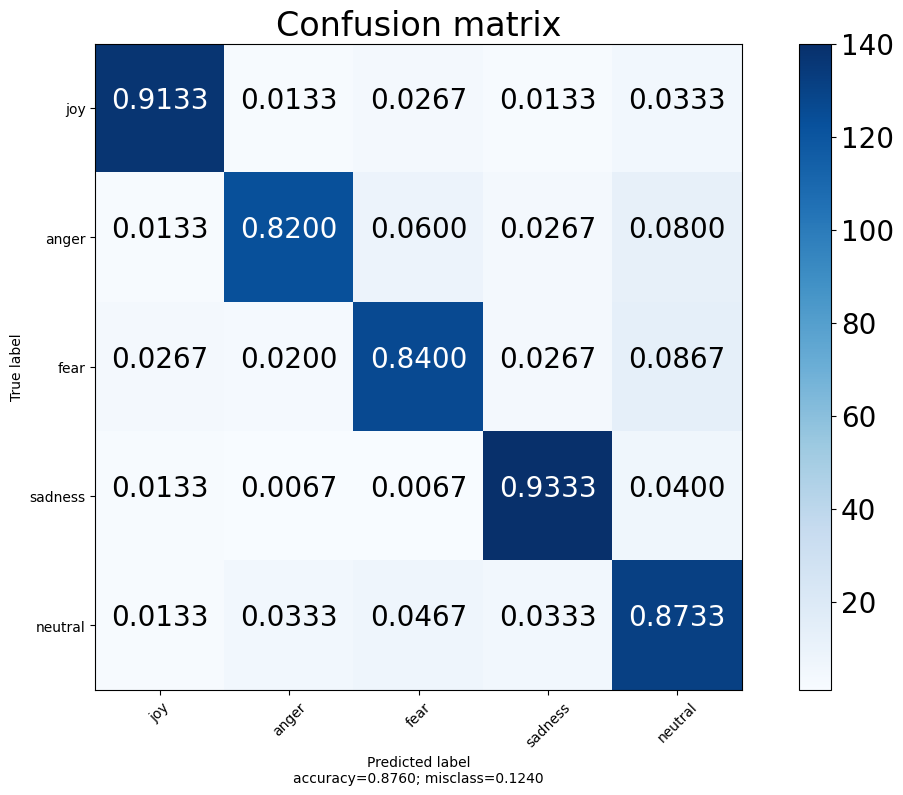

In [40]:
predicted = label_encoder.inverse_transform(predicted_labels)
cm = confusion_matrix(test_labels, predicted, labels=labels)
plot_confusion_matrix(cm, labels)

In [21]:
from torch.nn.functional import softmax

bert_model.eval()

with torch.no_grad():
    outputs = bert_model(**test_encodings)

    logits = outputs.logits

    probabilities = softmax(logits, dim=1)

probabilities_np = probabilities.cpu().numpy()
predicted_labels_np = torch.argmax(probabilities, dim=1).cpu().numpy()
test_labels_np = test_labels_tensor.cpu().numpy()

for i, text in enumerate(test_texts):
    print(f"Text: {text}")
    for j, emotion in enumerate(label_encoder.classes_):
        print(f"Probability of {emotion}: {probabilities_np[i, j]}")
    print("Predicted Emotion:", label_encoder.classes_[predicted_labels_np[i]])
    print("True Emotion:", label_encoder.classes_[test_labels_np[i]])
    print("\n")


Text:  depression  
Probability of anger: 0.0007440547924488783
Probability of fear: 0.00170200876891613
Probability of joy: 0.0008754062000662088
Probability of neutral: 0.0022933082655072212
Probability of sadness: 0.9943852424621582
Predicted Emotion: sadness
True Emotion: sadness


Text: peanut butter takes away sting 
Probability of anger: 0.9940640330314636
Probability of fear: 0.00229828548617661
Probability of joy: 0.0013073324225842953
Probability of neutral: 0.0018136358121410012
Probability of sadness: 0.0005166358314454556
Predicted Emotion: anger
True Emotion: anger


Text: mannnn  got iphone    im jealous  
Probability of anger: 0.8905501365661621
Probability of fear: 0.00770144397392869
Probability of joy: 0.011092078872025013
Probability of neutral: 0.08641061931848526
Probability of sadness: 0.004245731048285961
Predicted Emotion: anger
True Emotion: neutral


Text: speech bold coz nt written pm ns bt expressiontone dull n dim 
Probability of anger: 0.00129552907310426

In [23]:
text_to_predict = "Feeling a bit anxious about the presentation"

tokenized_text = tokenizer(text_to_predict, truncation=True, padding=True, return_tensors='pt', max_length=512)

with torch.no_grad():
    outputs = bert_model(**tokenized_text)
    logits = outputs.logits

    probabilities = softmax(logits, dim=1)

probabilities_np = probabilities.cpu().numpy()
predicted_label_np = torch.argmax(probabilities, dim=1).cpu().numpy()

print(f"Text: {text_to_predict}")
for j, emotion in enumerate(label_encoder.classes_):
    print(f"Probability of {emotion}: {probabilities_np[0, j]}")
print("Predicted Emotion:", label_encoder.classes_[predicted_label_np[0]])

Text: Feeling a bit anxious about the presentation
Probability of anger: 0.023017041385173798
Probability of fear: 0.4965920150279999
Probability of joy: 0.01633150316774845
Probability of neutral: 0.46078336238861084
Probability of sadness: 0.0032760321628302336
Predicted Emotion: fear


In [36]:
emotions = [
    "I hate getting up, it's so annoying.",
    "I love cats and their sweet noses.",
    "I put up with my schoolmates.",
    "This movie made me feel so happy!",
    "The traffic jam today was frustrating.",
    "Spending time with friends always brings joy.",
    "I feel lonely when I'm alone at home.",
    "Excited about the upcoming vacation!",
    "I love spending time with friends and family. It brings me so much joy!",
    "The rude behavior of that person made me really angry.",
    "I'm feeling neutral about the upcoming changes at work.",
    "Today is just another neutral day for me.",
    "The constant delays and issues with the project are making me angry.",
    "Winning the lottery would bring me immense joy and happiness!",
    "I don't have a strong opinion on the matter; I'm feeling quite neutral.",
    "The news about the recent event left me in deep sadness.",
    "Losing a loved one is an experience filled with sadness and grief.",
    "I have a neutral stance on the current political situation.",
    "I'm so happy right now!", "This is really frustrating."
    "Feeling sad and lonely tonight.",
    "I can't contain my excitement!",
    "Angry about the recent events.",
    "Today is a wonderful day!",
    "Dealing with a lot of stress.",
    "The movie made me cry, but it was beautiful.",
    "I'm thrilled about the upcoming project.",
    "Feeling a bit anxious about the presentation."
    "I'm afraid of spiders, they're so big!"
]

for text in emotions:
    tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='pt', max_length=512)

    tokenized_text = {key: val.to(device) for key, val in tokenized_text.items()}

    outputs = bert_model(**tokenized_text)

    logits = outputs.logits
    probabilities = softmax(logits, dim=1)

    predicted_label = torch.argmax(probabilities).item()
    decoded_emotion = label_encoder.classes_[predicted_label]

    print(f"'{text}' : {decoded_emotion}")

In [7]:
texts = []
predicted_emotions = []

for text in emotions:
    tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='pt', max_length=512)

    tokenized_text = {key: val.to(device) for key, val in tokenized_text.items()}

    outputs = bert_model(**tokenized_text)

    logits = outputs.logits
    probabilities = softmax(logits, dim=1)

    predicted_label = torch.argmax(probabilities).item()
    decoded_emotion = label_encoder.classes_[predicted_label]

    texts.append(text)
    predicted_emotions.append(decoded_emotion)

emotion_df = pd.DataFrame({'Text': texts, 'Predicted Emotion': predicted_emotions})

print(emotion_df)

NameError: name 'emotions' is not defined

In [24]:
model_save_path = "bert_model"

bert_model.save_pretrained(model_save_path)

In [29]:
save_path = "bert_model2"

bert_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('bert_model2\\tokenizer_config.json',
 'bert_model2\\special_tokens_map.json',
 'bert_model2\\vocab.txt',
 'bert_model2\\added_tokens.json')

In [17]:
from transformers import BertTokenizer, BertForSequenceClassification

model_load_path = "models/bert_model2/"

loaded_bert_model = BertForSequenceClassification.from_pretrained(model_load_path)
loaded_tokenizer = BertTokenizer.from_pretrained(model_load_path)

In [18]:
from torch.nn.functional import softmax
import torch

text_to_predict = "Today is a wonderful excitement day!"

tokenized_text = tokenizer(text_to_predict, truncation=True, padding=True, return_tensors='pt', max_length=512)

with torch.no_grad():
    outputs = loaded_bert_model(**tokenized_text)

    logits = outputs.logits

    probabilities = softmax(logits, dim=1)

probabilities_np = probabilities.cpu().numpy()

print(f"Text: {text_to_predict}")
for j, emotion in enumerate(label_encoder.classes_):
    print(f"Probability of {emotion}: {probabilities_np[0, j]}")
print("Predicted Emotion:", label_encoder.classes_[torch.argmax(probabilities, dim=1).item()])


Text: Today is a wonderful excitement day!
Probability of anger: 0.003633469808846712
Probability of fear: 0.008612258359789848
Probability of joy: 0.9843831658363342
Probability of neutral: 0.0027442765422165394
Probability of sadness: 0.0006268497090786695
Predicted Emotion: joy


In [39]:
from torch.nn.functional import softmax
import torch

text_to_predict = "I'm afraid of spiders, they're so big!"

tokenized_text = tokenizer(text_to_predict, truncation=True, padding=True, return_tensors='pt', max_length=512)

with torch.no_grad():
    outputs = loaded_bert_model(**tokenized_text)

    logits = outputs.logits

    probabilities = softmax(logits, dim=1)

probabilities_np = probabilities.cpu().numpy()

print(f"Text: {text_to_predict}")
for j, emotion in enumerate(label_encoder.classes_):
    print(f"Probability of {emotion}: {probabilities_np[0, j]}")
print("Predicted Emotion:", label_encoder.classes_[torch.argmax(probabilities, dim=1).item()])


Text: I'm afraid of spiders, they're so big!
Probability of anger: 0.010529370978474617
Probability of fear: 0.9822942018508911
Probability of joy: 0.0015460399445146322
Probability of neutral: 0.004858497530221939
Probability of sadness: 0.000771855004131794
Predicted Emotion: fear


In [19]:
emotions = [
    "I hate getting up, it's so annoying.",
    "I love cats and their sweet noses.",
    "I put up with my schoolmates.",
    "This movie made me feel so happy!",
    "The traffic jam today was frustrating.",
    "Spending time with friends always brings joy.",
    "I feel lonely when I'm alone at home.",
    "Excited about the upcoming vacation!",
    "I love spending time with friends and family. It brings me so much joy!",
    "The rude behavior of that person made me really angry.",
    "I'm feeling neutral about the upcoming changes at work.",
    "Today is just another neutral day for me.",
    "The constant delays and issues with the project are making me angry.",
    "Winning the lottery would bring me immense joy and happiness!",
    "I don't have a strong opinion on the matter; I'm feeling quite neutral.",
    "The news about the recent event left me in deep sadness.",
    "Losing a loved one is an experience filled with sadness and grief.",
    "I have a neutral stance on the current political situation.",
    "I'm so happy right now!", "This is really frustrating."
    "Feeling sad and lonely tonight.",
    "I can't contain my excitement!",
    "Angry about the recent events.",
    "Today is a wonderful day!",
    "Dealing with a lot of stress.",
    "The movie made me cry, but it was beautiful.",
    "I'm thrilled about the upcoming project.",
    "Feeling a bit anxious about the presentation."
    "I'm afraid of spiders, they're so big!"
]

texts = []
predicted_emotions = []
probabilities = []

for text in emotions:
    tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='pt', max_length=512)

    tokenized_text = {key: val.to(device) for key, val in tokenized_text.items()}

    with torch.no_grad():
        outputs = loaded_bert_model(**tokenized_text)

    logits = outputs.logits
    probabilities_tensor = softmax(logits, dim=1)

    predicted_label = torch.argmax(probabilities_tensor).item()
    decoded_emotion = label_encoder.classes_[predicted_label]
    probability = probabilities_tensor[0, predicted_label].item()  # Probability of the predicted class

    texts.append(text)
    predicted_emotions.append(decoded_emotion)
    probabilities.append(probability)

emotion_df = pd.DataFrame({'Text': texts, 'Predicted Emotion': predicted_emotions, 'Probability': probabilities})
emotion_df

,Text,Predicted Emotion,Probability
0,"I hate getting up, it's so annoying.",neutral,0.663908
1,I love cats and their sweet noses.,joy,0.936388
2,I put up with my schoolmates.,neutral,0.753806
3,This movie made me feel so happy!,joy,0.994885
4,The traffic jam today was frustrating.,neutral,0.659740
5,Spending time with friends always brings joy.,joy,0.995771
6,I feel lonely when I'm alone at home.,neutral,0.872889
7,Excited about the upcoming vacation!,anger,0.297468
8,I love spending time with friends and family. ...,joy,0.995701
9,The rude behavior of that person made me reall...,anger,0.994666
